# Every project starts with imports...

In [1]:
## For the sake of debugging
import pdb

## Data structures
import numpy as np 
import pandas as pd 

## Visualisation
import seaborn as sns 
import matplotlib.pyplot as plt 

## Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

## Models
# Tuning parameters
from sklearn.model_selection import GridSearchCV, cross_val_score

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.svm import SVC

# Neural Network
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

## Evaluation
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix

# Magic method used for displaying images directly in Jupyter Notebook
%matplotlib inline

Using TensorFlow backend.


# Loading up the data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
datasets = [train_df, test_df]

# Data analysis

In [3]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Check for missing data

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
def show_missing_values():
    nulls = train_df.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()

,Number,Percentage
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


### Missing Data - conclusions

There are missing values in three columns. 

First of them is 'Age' - there are 177 of 891 values are missing. Only two rows are missing in case of 'Embarked'. There are far less values of 'Cabin' column - only 204 of 891 are available.

Fonrtunately there are plenty of methods of dealing with such problems, but this problem will be solved later.

## Dependencies between data
A key to creating a good model is learning how does the data correlate - what are the dependencies between various attributes.

## Sex
There is a disparity between survivors depending on the sex - women were more likely to survive.

Text(0.5, 1.0, 'Survivors depending on the sex')

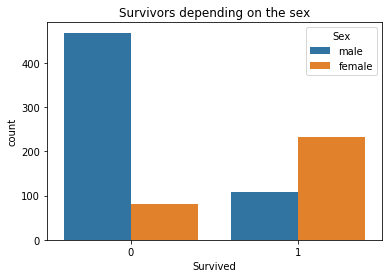

In [6]:
sns.countplot(x='Survived', hue='Sex', data=train_df)
plt.title('Survivors depending on the sex')

## Embarked
Most of the casualties were embarked in 'S'.

Text(0.5, 1.0, 'Survivors depending on the emberkment place')

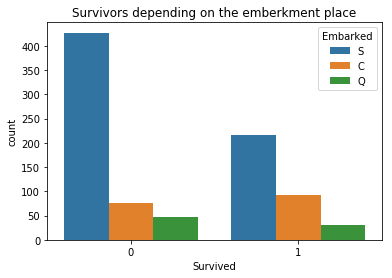

In [7]:
sns.countplot(x='Survived', hue='Embarked', data=train_df)
plt.title('Survivors depending on the emberkment place')

## Pclass
Passengers from the 3rd class were more likely to die during the cruise - they were the most of the casualties.
The number of people that survived, depending on the class, was rather even.

Text(0.5, 1.0, 'Survivors depending on the class')

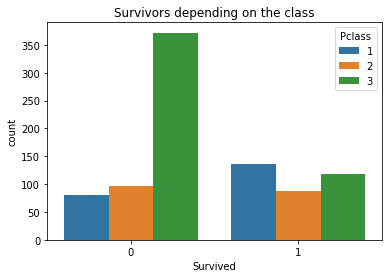

In [8]:
sns.countplot(x='Survived', hue='Pclass', data=train_df)
plt.title('Survivors depending on the class')

## Age
Male: 
* most of the survivors were between ages 20 to 40   

Female: 
* more survivors overall
* the difference between survival rate based on age is smaller than in case of men

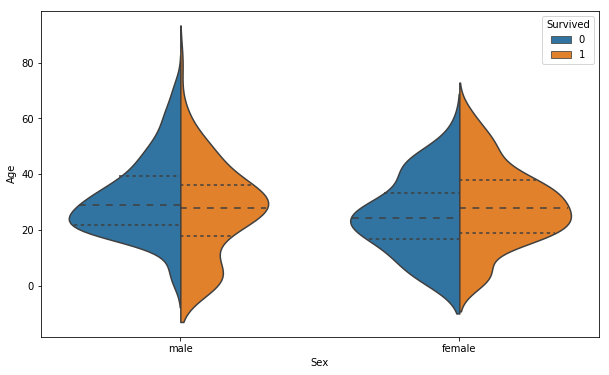

In [9]:
plt.figure(figsize=(10,6))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train_df, split=True, inner="quartile")

## Fare
It seems that passengers with cheaper tickets were more likely to die. Binning of this data might be difficult since the data is far from being normally distributed.

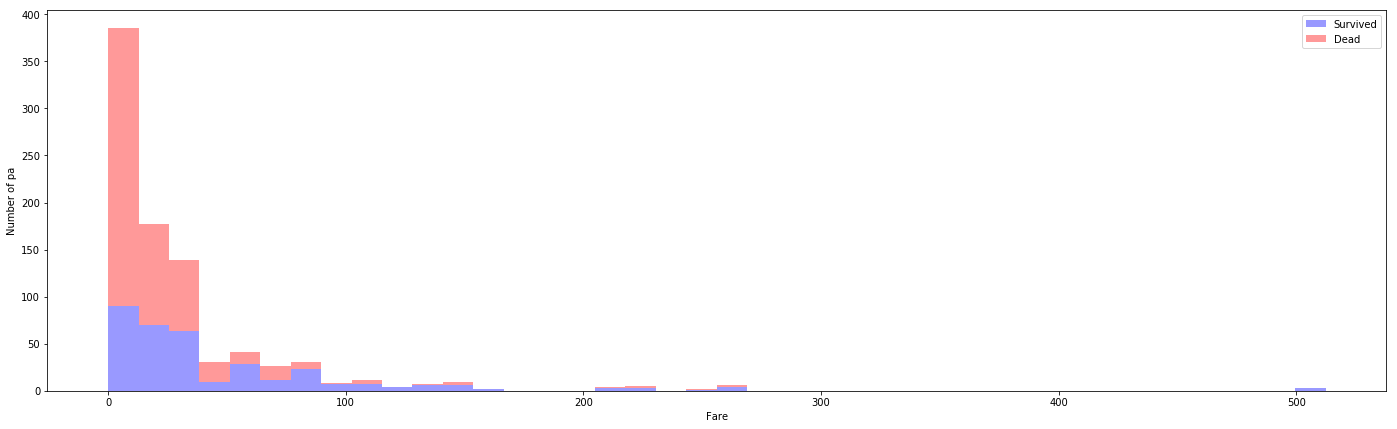

In [10]:
survived = train_df[train_df['Survived'] == 1]['Fare']
dead = train_df[train_df['Survived'] == 0]['Fare']

figure = plt.figure(figsize=(24,7))
plt.hist([survived, dead], stacked=True, color=['b','r'], alpha=0.4, bins=40, label=['Survived', 'Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of pa')
plt.legend()

# Data Preprocessing

## Dropping unrelevant data
Some of the data does not have any impact on the survival rate of the passengers and only increases the complexity of the dataset - it has to be erased.

### PassengerId, Ticket, Name
* PassengerId - it is only ordinal number of the passenger, does not influence survival rate
* Ticket - too much variance between tickets
* Name - would not be so relevant to the surviving the accident. But we will use it to fill the blank 'Age' values

In [11]:
columns_to_drop = ['PassengerId', 'Ticket', 'Name']
for d in datasets:
    d.drop(columns_to_drop, axis=1, inplace=True)

## Dealing with missing data
### Age 

An example approach would have be using for instance a mean to fill the blank 'Age' values

In [12]:
def fill_empty_age(dataset): 
    mean = dataset['Age'].mean()
    std = dataset['Age'].std()
    
    dataset['Age'].fillna(np.random.randint(mean - std, mean + std))
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

for d in datasets:
    fill_empty_age(d)

### Embarked
A standard approach is to fill missing data with the one that is most frequent - in this case Embarkment 'S'.

In [13]:
most_frequent_embarked = train_df['Embarked'].value_counts().axes[0][0]
most_frequent_embarked

'S'

In [14]:
imputer = SimpleImputer(missing_values='NaN', strategy='most_frequent')
for dataset in datasets:
    imputer.fit_transform(d)

### Cabin
There is a lot of missing information in this column - about 80%. It can be erased from the datasets.

In [15]:
for d in datasets: 
    d.drop('Cabin', axis=1, inplace=True)

## Categorical Features

The function below adds dummy columns from the given column and drops the original one.

In [16]:
def create_categorical_feature(dataset, column_to_modify):
    categorical = pd.get_dummies(dataset[column_to_modify], prefix=column_to_modify)
    dataset.drop(column_to_modify, axis=1, inplace=True)
    dataset = pd.concat([dataset, categorical], axis=1)
    return dataset

### Pclass

In [17]:
column = 'Pclass'
train_df = create_categorical_feature(train_df, column)
test_df = create_categorical_feature(test_df, column)

### Embarked

In [18]:
column = 'Embarked'
train_df = create_categorical_feature(train_df, column)
test_df = create_categorical_feature(test_df, column)

### Sex
There is no need for having two columns denoting sex - it only increases the complexity of the data.   
A good solution would be to drop one of the columns and keep the one denoting for instance if the person is male (1) or not (0).

In [19]:
def create_categorical_sex(dataset):
    encoder = LabelBinarizer()
    sex_categories = dataset['Sex']
    sex_categories_encoded = encoder.fit_transform(sex_categories)
    dataset['isMale'] = sex_categories_encoded
    dataset.drop('Sex', axis=1, inplace=True)
    return dataset

train_df = create_categorical_sex(train_df)
test_df = create_categorical_sex(test_df)

### Age

First convert continuous values to caregorical ones, by definining bins in which adequate ages will end up.

In [20]:
def categorize_ages(df):
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Old Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

train_df = categorize_ages(train_df)
test_df = categorize_ages(test_df)

Create dummy variables from categorized ages.

In [21]:
column = 'Age'
train_df = create_categorical_feature(train_df, 'Age')
test_df = create_categorical_feature(test_df, 'Age')

### Fare

In [22]:
pd.qcut(train_df['Fare'], 5).value_counts()

(7.854, 10.5]        184
(21.679, 39.688]     180
(-0.001, 7.854]      179
(39.688, 512.329]    176
(10.5, 21.679]       172
Name: Fare, dtype: int64

In [23]:
def convert_fares(fare): 
    if fare <= 7.854: 
        return 0
    elif fare > 7.854 and fare <= 10.5: 
        return 1
    elif fare > 10.5 and fare <= 21.679:
        return 2
    elif fare > 21.679 and fare <= 39.688: 
        return 3
    else: 
        return 4

for dataset in datasets:
    dataset['Fare'] = dataset['Fare'].apply(lambda fare: convert_fares(fare))

## Feature Engineering
Columns 'SibSp' and 'Parch' denote very similar thing - number of relatives. This can be represented as one column 'Relatives'.

In [24]:
for d in datasets:
    relatives = d['SibSp'] + d['Parch']
    d['Relatives'] = relatives
    d.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [25]:
def split_datasets(dataset):    
    results_cols = ['Survived']
    prediction_cols = [col for col in dataset.columns if col not in results_cols]
    return dataset[prediction_cols], dataset[results_cols]

In [26]:
X_train, y_train = split_datasets(train_df)
y_train = y_train.values.ravel()
# X_test, y_test = split_datasets(test_df)

## Feature Scaling

In [27]:
scaler = StandardScaler()

def scale_features(dataset): 
    return scaler.fit_transform(dataset.astype(float))

In [28]:
X_train = scale_features(X_train)

# Create Models

Since the problem is a classification task, it will require classification models.   
Let's try SVM, RandomForest and a Simple Neural Network.

## GridSearch
In order to find best parameters of the classifiers GridSearch will be used.

In [29]:
def find_best_parameters(model, parameters, X, y, cv=10, verbose=1, n_jobs=-1):
    grid_object = GridSearchCV(model, parameters, scoring=make_scorer(accuracy_score), cv=cv, verbose=verbose, n_jobs=n_jobs, iid=True)
    grid_object = grid_object.fit(X, y)
    return grid_object.best_estimator_

## SVM

In [30]:
svm = SVC()

parameters = {'C': [1.0, 2.0, 4.0], 
              'gamma': [0.001, 0.1, 1., 10.]
             }

svm = find_best_parameters(svm, parameters, X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.1s finished


## Random Forest

In [31]:
random_forest = RandomForestClassifier()

parameters = {'n_estimators': [20, 40, 80, 160], 
              'max_features': ['log2', 'sqrt','auto']
             }

random_forest = find_best_parameters(random_forest, parameters, X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.8s finished


## Simple Neural Network

A simple Artificial Neural Network with 15 input nodes (number of columns), 2 hidden layers and 1 output node.

In [32]:
def create_model(activation_func='relu'):
    
    model = Sequential()
    model.add(Dense(15, activation=activation_func))
    model.add(Dense(7, activation=activation_func))
    model.add(Dense(3, activation=activation_func))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [33]:
neural_net = KerasClassifier(build_fn=create_model, epochs=500, batch_size=32)
# history = neural_net.fit(X_train, y_train.as_matrix(), epochs=500, batch_size=32)

# Pick best model

In [34]:
def measure_classifier_accuracy(classifier, X, y):
    predictions = classifier.predict(X)
    return accuracy_score(y, predictions), confusion_matrix(y, predictions)

In [35]:
%%capture
svm_scores = cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=10)
random_forest_scores = cross_val_score(random_forest, X_train, y_train, scoring='accuracy', cv=10)
neural_net_scores = cross_val_score(neural_net, X_train, y_train, scoring='accuracy', cv=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [36]:
results = [
    ['Random Forest', np.mean(svm_scores)],
    ['Neural Network', np.mean(neural_net_scores)],
    ['SVM', np.mean(random_forest_scores)]
]

results.sort(key = lambda model: model[1])
results = pd.DataFrame(data=results, columns=['Model', 'Score'])
results

,Model,Score
0,SVM,0.800358
1,Neural Network,0.808102
2,Random Forest,0.823904


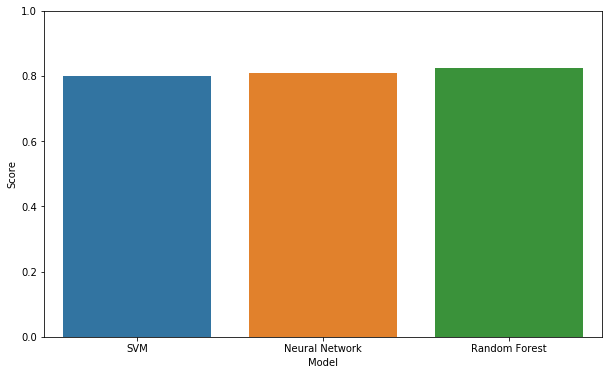

In [37]:
plt.figure(figsize=(10,6))
plot=sns.barplot(x='Model', y='Score', data=results)
plot.set(ylim=(0, 1))
plt.show()

# Summary

The results show that Random Forest was the best classifier for this task basing on the state of the dataset and the parameters that were evaluated during GridSearch. The difference between the algorithms was quite small - about 1%.

## Possible Future Work

There are still some possible approaches that might increase the efficiency of the classification task.


### Change way bins were calculated 

Number of bins (k) and its width (h) can be determined using many various rules that include:

1. **Friedman-Diaconis rule**
$$h=2 \frac{IQR(x)}{n^{1/3}}$$

2. Scott's normal reference rule
$$h=\frac{3.5 \cdot \sigma}{n^{1/3}}$$



I have tried to use **two solutions** for this problem - first one was rather naive split of the values into 5 bins, the other one was according to FD rule. <br>


### Change the way missing 'Age' was calculated
For instance set it on the basis of the 'Name' value - people with some titles tend to be older.

### Use different models 
There are plenty of models that can be applied to this task: Logistic Regression or Naive Bayes.

### Explore another parameters of currently used models
Grid and Random Search are really handy in such cases.